## Metabolomics Workbench integration

Download and process workbench studies

In [1]:
import requests
import pandas as pd
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
import libchebipy

import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.multitest import multipletests
import glob
import sspa

In [2]:
base_url = 'https://www.metabolomicsworkbench.org/rest/study/analysis_id/'

In [3]:
studies = ['ST000041', 'ST002829', 'ST001420', 'ST001789','ST001412', 'ST002016', 'ST001736', 'ST002301', 'ST001933', 'ST000899', 'ST000284', 'ST002428', 'ST000974', 'ST002100', 'ST001940', 'ST002498']
studies_assays = dict.fromkeys(studies)

In [4]:
studies_assays

{'ST000041': None,
 'ST002829': None,
 'ST001420': None,
 'ST001789': None,
 'ST001412': None,
 'ST002016': None,
 'ST001736': None,
 'ST002301': None,
 'ST001933': None,
 'ST000899': None,
 'ST000284': None,
 'ST002428': None,
 'ST000974': None,
 'ST002100': None,
 'ST001940': None,
 'ST002498': None}

In [5]:
# Get assays for each study
for s in studies:
    
    base_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/repl/analysis'
    resp = requests.get(base_url.replace('repl', s)).json()
    print(resp)
    if list(resp.keys())[0] != '1':
        resp_series = pd.Series(resp)
        print(resp_series['analysis_id'])
        studies_assays[s] = [resp_series['analysis_id']]
    else:
        resp_df = pd.DataFrame.from_dict(resp).T
        print(resp_df['analysis_id'].tolist())
        studies_assays[s] = resp_df['analysis_id'].tolist()



{'1': {'study_id': 'ST000041', 'analysis_id': 'AN000062', 'analysis_summary': 'MS negative ion mode', 'analysis_type': 'MS', 'chromatography system': 'Agilent 1200', 'column_name': 'Waters Acquity HSS T3', 'chromatography_type': 'Reversed phase', 'ms_instrument_name': 'Agilent 6530 QTOF', 'ms_instrument_type': 'QTOF', 'ms_type': 'ESI', 'ion_mode': 'NEGATIVE', 'nmr_instrument_type': '', 'nmr_experiment_type': '', 'spectrometer_frequency': '', 'nmr_solvent': '', 'units': 'Counts'}, '2': {'study_id': 'ST000041', 'analysis_id': 'AN000063', 'analysis_summary': 'MS positive ion mode', 'analysis_type': 'MS', 'chromatography system': 'Agilent 1200', 'column_name': 'Waters Acquity HSS T3', 'chromatography_type': 'Reversed phase', 'ms_instrument_name': 'Agilent 6530 QTOF', 'ms_instrument_type': 'QTOF', 'ms_type': 'ESI', 'ion_mode': 'POSITIVE', 'nmr_instrument_type': '', 'nmr_experiment_type': '', 'spectrometer_frequency': '', 'nmr_solvent': '', 'units': 'Counts'}}
['AN000062', 'AN000063']
{'1': 

In [6]:
# download all assays per study
for study in studies:
    print(study)
    base_url = 'https://www.metabolomicsworkbench.org/rest/study/analysis_id/'
    #check if directory exists
    if not os.path.isdir('Studies/'+study):
        os.mkdir('Studies/'+study)

        for assay in studies_assays[study]:
            url = base_url + assay + '/datatable/file'
            print(url)
            pd.read_csv(url, sep='\t').to_csv('Studies/'+study+'/'+f'{assay}.csv', index=False)
    else:
        pass

ST000041


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Studies/ST000041'

In [ ]:
# manually edit metadata
an002826 = pd.read_csv('Studies/ST001736/AN002826.csv')
an002826['Class'] = an002826['Class'].str.split(' | ').str[0]
an002826.to_csv('Studies/ST001736/AN002826.csv', index=False)

an002827 = pd.read_csv('Studies/ST001736/AN002827.csv')
an002827['Class'] = an002827['Class'].str.split(' | ').str[0]
an002827.to_csv('Studies/ST001736/AN002827.csv', index=False)

In [ ]:
# manually edit metadata
for filepath in glob.iglob('Studies/ST002829/*'):
    print(filepath)

    assay = pd.read_csv(filepath)
    assay['Class'] = assay['Class'].str.split(' | ').str[2]
    assay.to_csv(filepath, index=False)


Studies/ST002829\AN004619.csv
Studies/ST002829\AN004620.csv
Studies/ST002829\AN004621.csv
Studies/ST002829\AN004622.csv


In [ ]:
for filepath in glob.iglob('Studies/ST000041/*'):
    print(filepath)

    assay = pd.read_csv(filepath)
    assay['Class'] = assay['Class'].str.split(' | ').str[0]
    assay.to_csv(filepath, index=False)

Studies/ST000041\AN000062.csv
Studies/ST000041\AN000063.csv


In [ ]:
refmet = pd.read_csv('refmet.csv', dtype=object)
name2class = dict(zip(refmet[' refmet_name'], refmet['super_class']))

class WorkbenchDataset:
    '''AN003284.csv
    Class to process Metabolomics Workbench datasets
    '''

    def __init__(self, study_id, md_filter, name, outliers=None, remove_suffix=None, pathway_level=False):
        self.study_id = study_id
        self.md_filter = md_filter
        self.raw_data = None
        self.outliers = outliers
        self.pathway_level = pathway_level
        self.pathway_coverage = None
        self.pathway_data = None
        self.DA_metabolites = None
        self.node_name = study_id
        self.remove_suffix = remove_suffix
        self.name = name
        self.compound_classes = None

        self.read_data()
        # self.get_pathway_data()
        self.da_testing()

    def read_data(self):
        # check if there are multiple files in folder
        files = glob.glob('Studies/'+self.study_id+'/*.csv')
        if len(files) > 1:
            # read in all files and concatenate
            dfs = []
            dfs_proc = []
            for f in files:
                df = pd.read_csv(f)
                dfs.append(df)
                df.index = df['Samples']
                self.raw_data = df

                df_proc = self.preprocess_data()
                dfs_proc.append(df_proc)

            self.raw_data = pd.concat(dfs, axis=1)
            self.processed_data = pd.concat(dfs_proc, axis=1)
            self.processed_data = self.processed_data.loc[:, ~self.processed_data.columns.duplicated()]
            # move group column to end
            cols = [col for col in self.processed_data.columns if col != 'Group'] + ['Group']
            self.processed_data = self.processed_data[cols]

        else:
            data = pd.read_csv(files[0])
            data.index = data['Samples']
            self.raw_data = data

            data_proc = self.preprocess_data()
            self.processed_data = data_proc


        metadata = self.raw_data['Class']
        self.metadata = metadata

        return self.processed_data, self.metadata
    
    def preprocess_data(self):
        '''Preprocess data'''
        data_filt = self.raw_data.copy()
        # drop duplicate columns

        # filter on metadata
        md_dict = dict(zip(self.raw_data['Samples'], self.raw_data['Class']))
        data_filt = data_filt[data_filt['Class'].isin(self.md_filter.values())]
        data_filt = data_filt.drop(columns=['Class', 'Samples'])

        # convert to refmet id
        mets_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/repl/metabolites'
        mets = requests.get(mets_url.replace('repl', self.study_id)).text
        mets_df = pd.read_json(mets).T
        mets_dict = dict(zip(mets_df['metabolite_name'], mets_df['refmet_name']))
        data_filt.columns = data_filt.columns.map(mets_dict)

        # drop na column names
        data_filt = data_filt.loc[:, data_filt.columns.notna()]

        try:
            data_filt = data_filt.drop(columns=[''])
        except KeyError:
            pass

        # drop outliers
        if self.outliers:
            data_filt = data_filt.drop(self.outliers)

        # Missingness checks 
        # replace empty strings with NaN
        data_filt = data_filt.replace(['', ' ', 0], np.nan)
        # Delete colums and rows where all values are missing
        data_filt = data_filt.dropna(axis=0, how='all')
        data_filt = data_filt.dropna(axis=1, how='all')

        # Delete rows and columns where all values are 0 
        data_filt = data_filt.loc[:, (data_filt != 0).any(axis=0)]
        data_filt = data_filt.loc[(data_filt != 0).any(axis=1), :]

        data_filt = data_filt.dropna(axis=1, thresh=0.5*data_filt.shape[0])
        missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100
        print(f"Missingness: {missing_pct:.2f}%")

        # impute missing values
        imputer = KNNImputer(n_neighbors=2, weights="uniform").set_output(transform="pandas")
        data_imputed = imputer.fit_transform(data_filt)

        # delete cols where all values are the same
        data_imputed = data_imputed[[i for i in data_imputed if len(set(data_imputed[i]))>1]]

        # log transformation
        data_imputed = np.log(data_imputed + 1)

        # standardize
        scaler = StandardScaler().set_output(transform="pandas")
        data_scaled = scaler.fit_transform(data_imputed)

        data_scaled['Group'] = data_scaled.index.map(md_dict)

        # self.processed_data = data_scaled
        self.compound_classes = {k: name2class[k] if k in name2class.keys() else None for k in data_scaled.columns[:-1]}

        return data_scaled


    def get_pathway_data(self):
        reactome_paths = sspa.process_gmt(infile='../MetDMN/Reactome_Homo_sapiens_pathways_ChEBI_R88.gmt')
        reactome_dict = sspa.utils.pathwaydf_to_dict(reactome_paths)
        data = self.processed_data

        # convert to pubchem
        pubchem_conv = {k: name2pubchem[k] if k in name2pubchem.keys() else None for k in data.columns[:-1]}
        chebi_ids = {k: pubchem_to_chebi(v) for k, v in pubchem_conv.items()}
        print(chebi_ids)


        # store pathway coverage stats
        cvrg_dict = {k: len(set(data.columns).intersection(set(v))) for k, v in reactome_dict.items()}
        self.pathway_coverage = cvrg_dict

        scores = sspa.sspa_KPCA(reactome_paths).fit_transform(data.iloc[:, :-1])
        scores['Group'] = self.processed_data['Group']
        self.pathway_data = scores
 
    def plot_qc(self):
        # PCA biplot
        pca = PCA(n_components=2).set_output(transform="pandas")
        pca_result = pca.fit_transform(self.processed_data.iloc[:, :-1])
        self.pca = pca_result

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.scatterplot(
            x=pca_result.iloc[:, 0], y=pca_result.iloc[:, 1],
            hue="Group",
            data=self.processed_data,
            alpha=0.7,
            ax=ax1
        )

        # normality every nth feature
        normaliser = 10 * self.processed_data.shape[1]
        data_long = self.processed_data.melt(id_vars='Group')
        sns.boxplot(data=data_long.iloc[0:normaliser, :], ax=ax2, hue='Group', x='variable', y='value')
        ax2.axhline(0, color='red', linestyle='--')
        plt.show()


    def da_testing(self):

        if self.pathway_level == True:
            dat = self.pathway_data
        else:
            dat = self.processed_data

        # t-test for two groups
        case = self.md_filter['Case']
        control = self.md_filter['Control']
        
        stat, pvals = stats.ttest_ind(dat[dat['Group'] == case].iloc[:, :-1],
                        dat[dat['Group'] == control].iloc[:, :-1],
                        alternative='two-sided', nan_policy='raise')
        pval_df = pd.DataFrame(pvals, index=dat.columns[:-1], columns=['P-value'])
        pval_df['Stat'] = stat
        pval_df['Direction'] = ['Up' if x > 0 else 'Down' for x in stat]
        self.pval_df = pval_df

        # fdr correction 
        pval_df['FDR_P-value'] = multipletests(pvals, method='fdr_bh')[1]

        # return significant metabolites
        self.DA_metabolites = pval_df[pval_df['FDR_P-value'] < 0.05].index.tolist()
        print(f"Number of differentially abundant metabolites: {len(self.DA_metabolites)}") 

        # generate tuples for nx links
        self.connection = [(self.node_name, met) for met in self.DA_metabolites]
        self.full_connection = [(self.node_name, met) for met in self.processed_data.columns[:-1]]



In [ ]:
def get_chebi_id_from_pubchem(pubchem_id):
    # Base URL for PubChem PUG-REST API
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{pubchem_id}/xrefs/JSON"
    
    # Make the request to PubChem
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code != 200:
        print(f"Error fetching data from PubChem. Status code: {response.status_code}")
        return None
    
    # Parse the JSON response
    data = response.json()
    
    # Extract ChEBI ID from the response
    for item in data.get('InformationList', {}).get('Information', []):
        if 'CHEBI' in item.get('ExternalID', {}):
            return item['ExternalID']['CHEBI']
    
    # If ChEBI ID is not found
    return None



## COVID

In [ ]:
# manually edit 
an003284 = pd.read_csv('Studies\ST002016\AN003284.csv')

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
C:\Users\cw2019\AppData\Local\Temp\ipykernel_29584\3726228951.py:2: SyntaxWarning: invalid escape sequence '\S'
  an003284 = pd.read_csv('Studies\ST002016\AN003284.csv')


In [ ]:
an003284[an003284.Samples.str.contains('NEG')]

,Samples,Class,10-Hydroxycarbazepine,11-Aminoundecanoic acid,11-Nitro-1-undecene,1-(1Z-hexadecenyl)-sn-glycero-3-phosphocholine,12-Aminododecanoic acid,12-Hydroxydihydrochelirubine,1_3_5-Heptatriene,1_3-Dicyclohexylurea,...,Venlafaxine,Veronal,Vestitol,Xanthine,Xanthohumol,Zalcitabine,Zearalenone,(Z)-Thiamethoxam,α-Aspartylphenylalanine,γ-Linolenic acid ethyl ester
0,Blank_01_NEG,group:-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Blank_02_NEG,group:-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Pooled_QC_ID_01_NEG,group:-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Pooled_QC_ID_02_NEG,group:-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Pooled_QC_ID_03_NEG,group:-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,QC5_NEG,group:QC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
314,QC6_NEG,group:QC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
316,QC7_NEG,group:QC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
318,QC8_NEG,group:QC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
an003284 = an003284[~an003284.Samples.str.contains('NEG')]

In [ ]:
an003284.Samples = an003284.Samples.str[:-4]

In [ ]:
an003284.to_csv('Studies\ST002016\AN003284.csv', index=False)

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\cw2019\AppData\Local\Temp\ipykernel_29584\4122490758.py:1: SyntaxWarning: invalid escape sequence '\S'
  an003284.to_csv('Studies\ST002016\AN003284.csv', index=False)


In [ ]:
# manually edit 
an003285 = pd.read_csv('Studies\ST002016\AN003285.csv')
an003285 = an003285[~an003285.Samples.str.contains('POS')]
an003285.Samples = an003285.Samples.str[:-4]
an003285.to_csv('Studies\ST002016\AN003285.csv', index=False)

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:5: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:5: SyntaxWarning: invalid escape sequence '\S'
C:\Users\cw2019\AppData\Local\Temp\ipykernel_29584\731885699.py:2: SyntaxWarning: invalid escape sequence '\S'
  an003285 = pd.read_csv('Studies\ST002016\AN003285.csv')
C:\Users\cw2019\AppData\Local\Temp\ipykernel_29584\731885699.py:5: SyntaxWarning: invalid escape sequence '\S'
  an003285.to_csv('Studies\ST002016\AN003285.csv', index=False)


In [ ]:
ST002016 = WorkbenchDataset(
    study_id='ST002016',
    md_filter={'Control': 'group:Healthy', 'Case': 'group:COVID_non-acute'},
    name = 'COVID'
)

C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 0.00%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 0.00%
Number of differentially abundant metabolites: 143


In [ ]:
ST002016.processed_data['Group'].value_counts()

Group
group:COVID_non-acute    48
group:Healthy            48
Name: count, dtype: int64

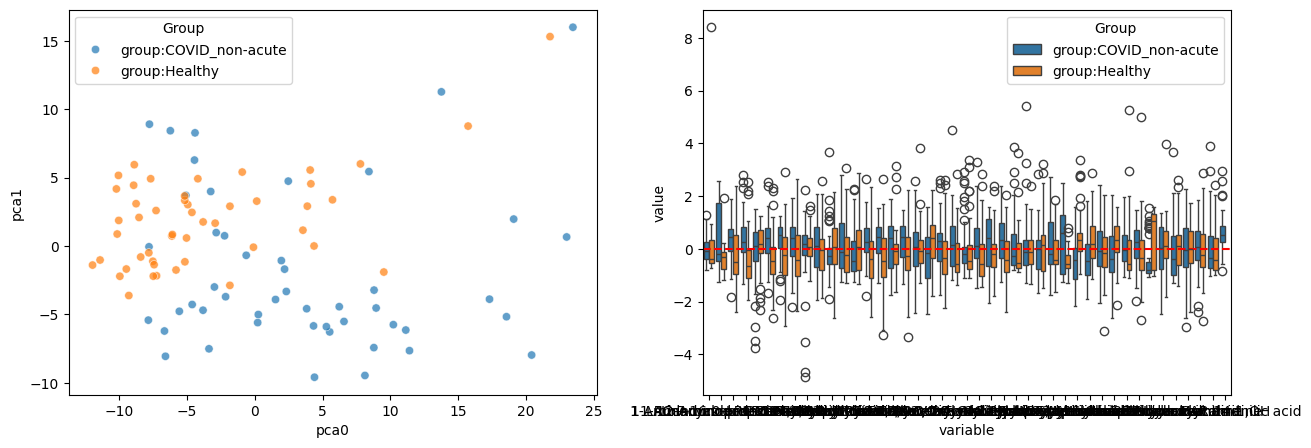

In [ ]:
ST002016.plot_qc()

In [ ]:
ST002301 = WorkbenchDataset(
    study_id='ST002301',
    name='COVID',
    # filepath='AN003757.csv',
    md_filter={'Control': 'Severity of Disease:Asymptomatic', 'Case': 'Severity of Disease:Severe'})

Missingness: 3.78%
Number of differentially abundant metabolites: 31


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


In [ ]:
ST002301.processed_data['Group'].value_counts()

Group
Severity of Disease:Severe          90
Severity of Disease:Asymptomatic    60
Name: count, dtype: int64

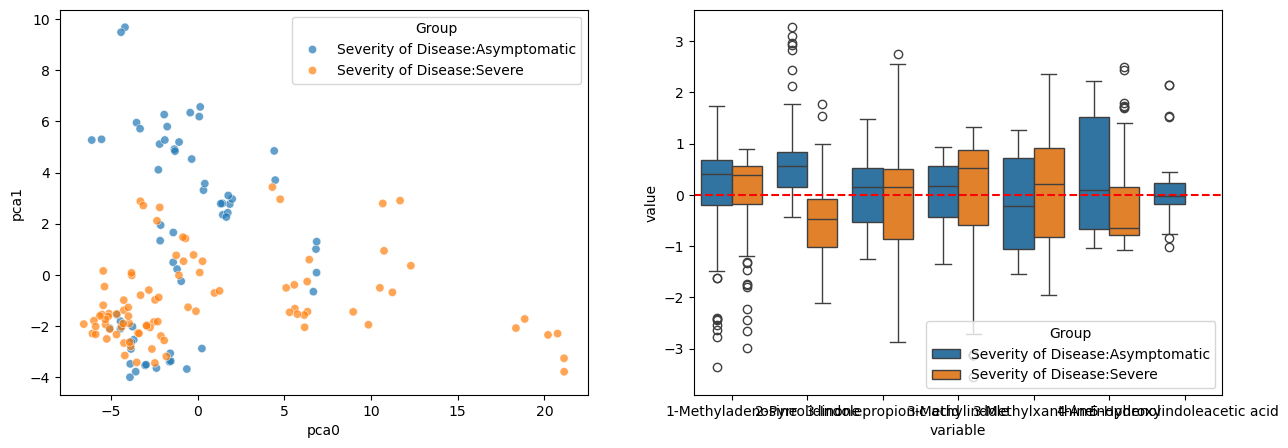

In [ ]:
ST002301.plot_qc()

In [ ]:
ST001736 = WorkbenchDataset(
    study_id='ST001736',
    name='COVID',
    # filepath='AN002826_updated.csv',
    md_filter={'Control': 'COVID_Status:Negative', 'Case': 'COVID_Status:Positive'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 0.82%
Missingness: 2.72%
Number of differentially abundant metabolites: 3


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


In [ ]:
ST001736.processed_data['Group'].value_counts()

Group
COVID_Status:Positive    71
COVID_Status:Negative    31
Name: count, dtype: int64

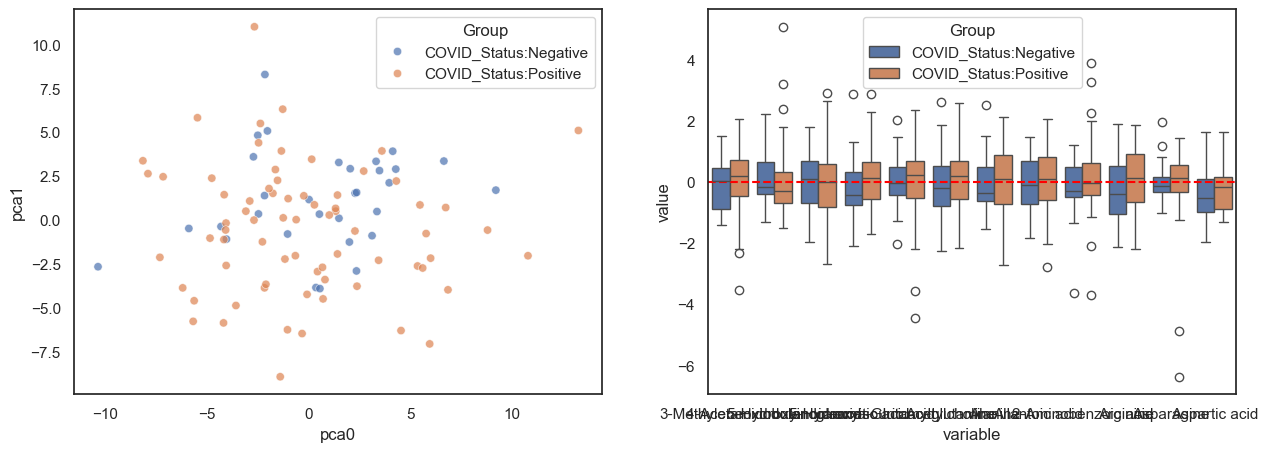

In [ ]:
ST001736.plot_qc()

In [ ]:
ST001933 = WorkbenchDataset(
    study_id='ST001933',
    name='COVID',
    md_filter={'Control': 'Group:H', 'Case': 'Group:CA'})

Missingness: 2.88%
Number of differentially abundant metabolites: 1


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


In [ ]:
ST001933.processed_data['Group'].value_counts()

Group
Group:H     35
Group:CA    17
Name: count, dtype: int64

In [ ]:
ST001933.processed_data.shape

(52, 180)

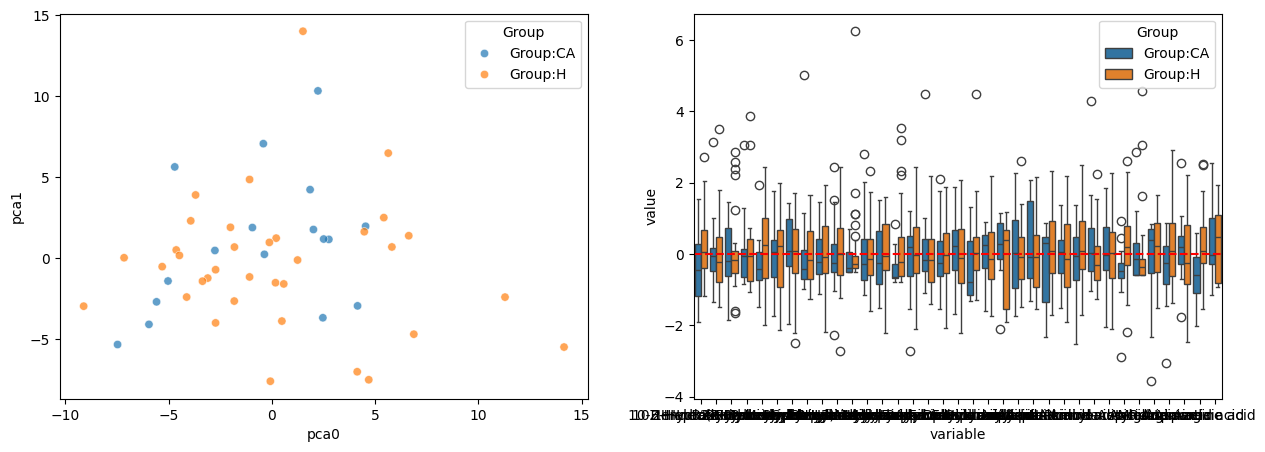

In [ ]:
ST001933.plot_qc()

## IBD

In [ ]:
ST000899 = WorkbenchDataset(
    study_id='ST000899',
    name='IBD',
    md_filter={'Control': 'Type:Control', 'Case': 'Type:Ulcerative Colitis'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 7.14%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 1.73%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 5.29%
Missingness: 2.80%
Number of differentially abundant metabolites: 0


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


In [ ]:
ST000899.processed_data['Group'].value_counts()

Group
Type:Control               20
Type:Ulcerative Colitis    20
Name: count, dtype: int64

In [ ]:
ST000899.processed_data.shape   

(40, 519)

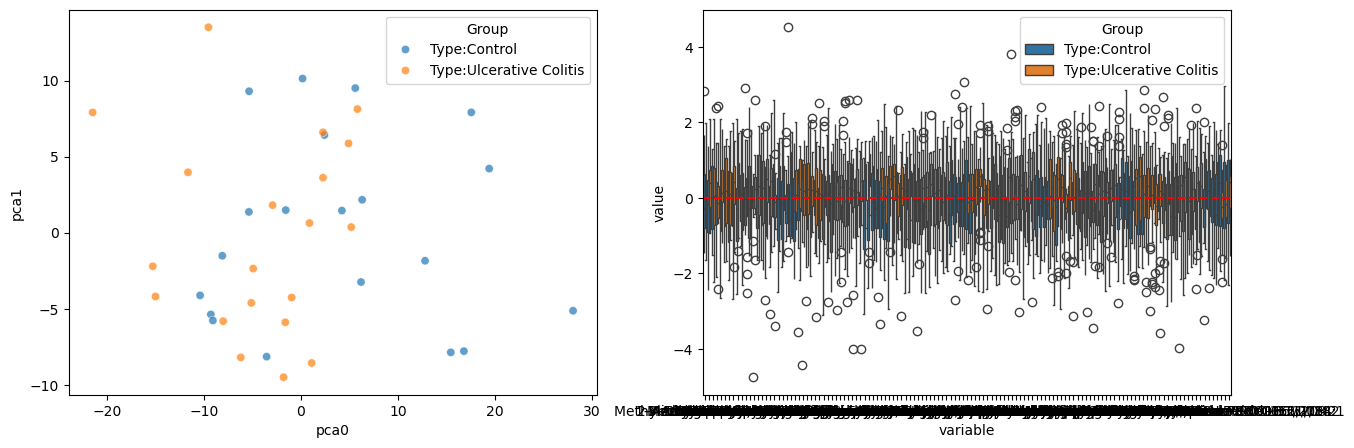

In [ ]:
ST000899.plot_qc()

## Cancer

In [ ]:
ST000284 = WorkbenchDataset(
    study_id='ST000284',
    name='Colorectal cancer',
    md_filter={'Control': 'Patient group:Healthy', 'Case': 'Patient group:CRC'})

Missingness: 0.00%
Number of differentially abundant metabolites: 7


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


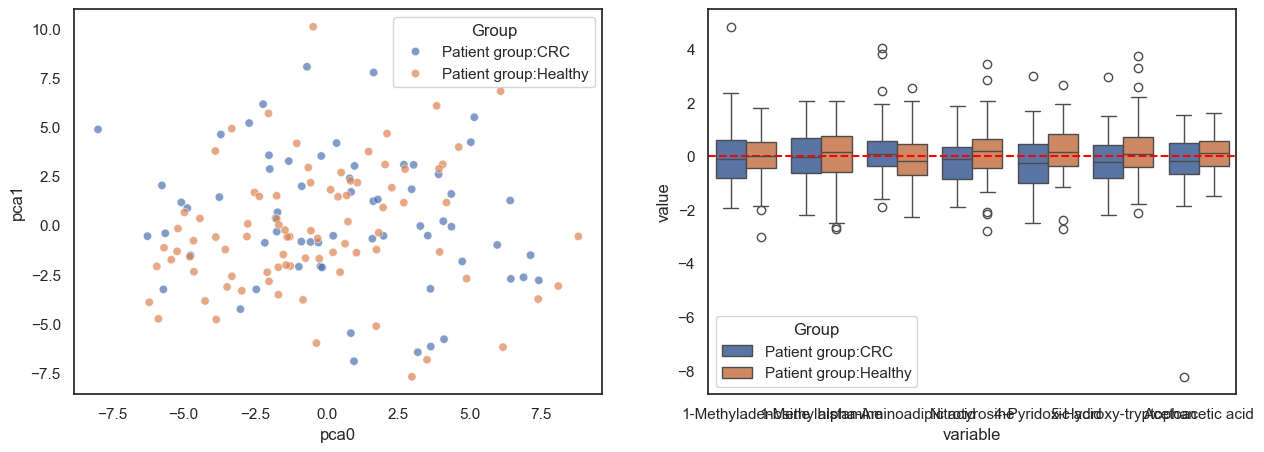

In [ ]:
ST000284.plot_qc()

In [ ]:
ST000284.processed_data.shape

(148, 102)

In [ ]:
ST000284.processed_data['Group'].value_counts()

Group
Patient group:Healthy    84
Patient group:CRC        64
Name: count, dtype: int64

## TB

In [ ]:
ST002428 = WorkbenchDataset(
    study_id='ST002428',
    # filepath='AN002826_updated.csv',
    name='Tuberculosis',
    md_filter={'Control': 'Label:Controls', 'Case': 'Label:TB'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 5.08%
Missingness: 4.91%
Number of differentially abundant metabolites: 21


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T
c:\Users\cw2019\AppData\Local\R\cache\R\basilisk\1.16.0\0\envs\py12\Lib\site-packages\scipy\stats\_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


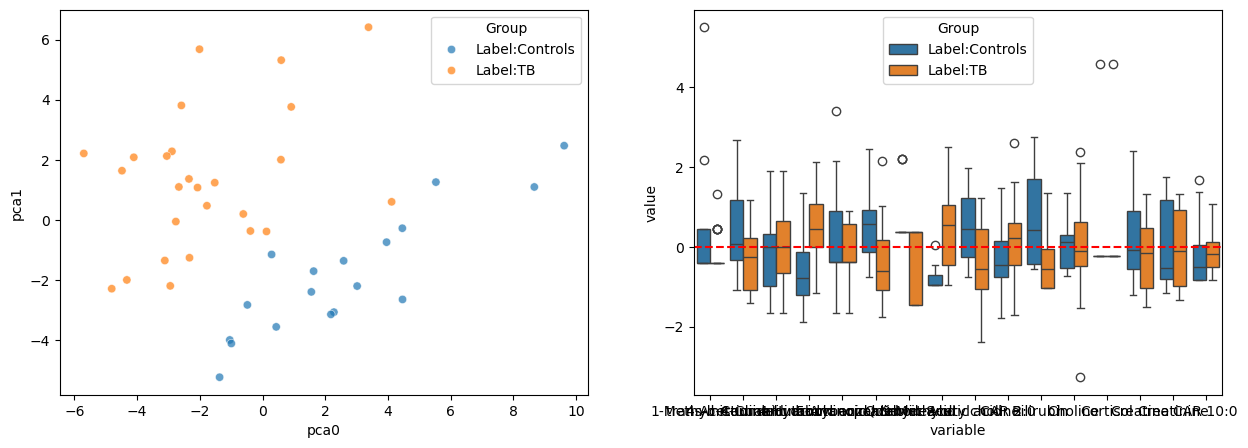

In [ ]:
ST002428.plot_qc()

In [ ]:
#split md
st000974 = pd.read_csv('Studies\ST000974\AN001595.csv')


<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\1668443190.py:2: SyntaxWarning: invalid escape sequence '\S'
  st000974 = pd.read_csv('Studies\ST000974\AN001595.csv')


In [ ]:
st000974['Class'] = st000974['Class'].str.split(' | ').str[0]

In [ ]:
st000974.to_csv('Studies\ST000974\AN001595.csv', index=False)

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\3511435816.py:1: SyntaxWarning: invalid escape sequence '\S'
  st000974.to_csv('Studies\ST000974\AN001595.csv', index=False)


In [ ]:
ST000974 = WorkbenchDataset(
    study_id='ST000974',
    name='TB',
    # filepath='AN002826_updated.csv',
    md_filter={'Control': 'GROUP:control', 'Case': 'GROUP:case'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 0.26%
Number of differentially abundant metabolites: 1


c:\Users\cw2019\AppData\Local\R\cache\R\basilisk\1.16.0\0\envs\py12\Lib\site-packages\scipy\stats\_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


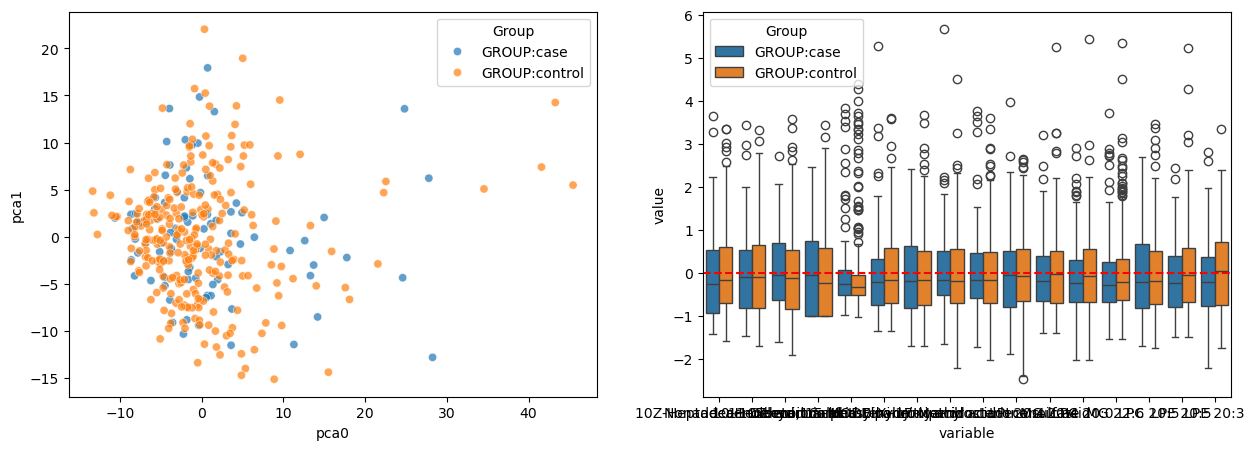

In [ ]:
ST000974.plot_qc()


## Hepatitis

In [ ]:

ST002100 = WorkbenchDataset(
    study_id='ST002100',
    name='Hepatitis',
    # filepath='AN002826_updated.csv',
    md_filter={'Control': 'Treatment:Healthy', 'Case': 'Treatment:Acute hepatitis'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 0.00%
Missingness: 0.00%
Number of differentially abundant metabolites: 46


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


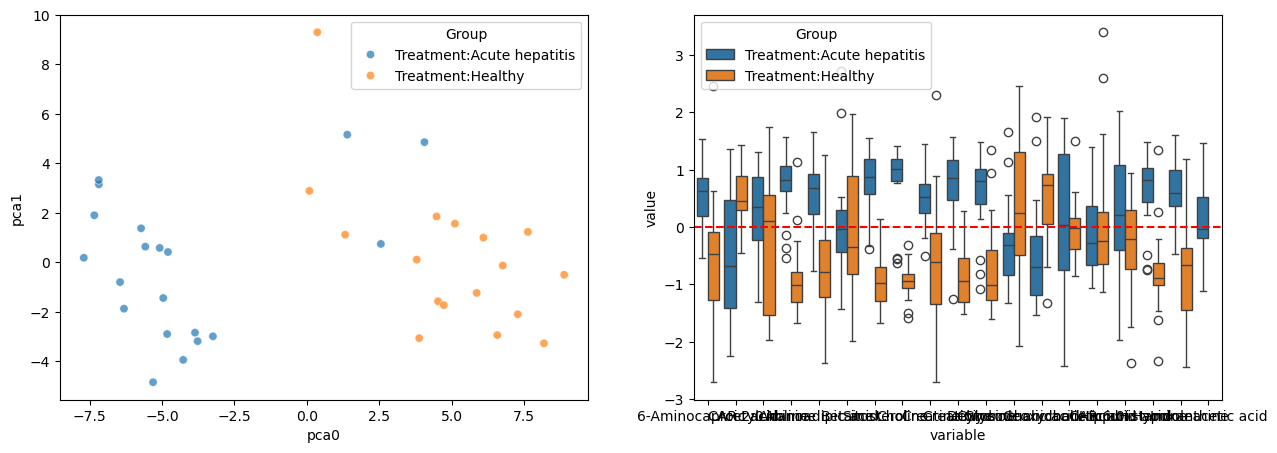

In [ ]:
ST002100.plot_qc()

In [ ]:
ST002100.processed_data['Group'].value_counts()

Group
Treatment:Acute hepatitis    20
Treatment:Healthy            17
Name: count, dtype: int64

## IBD/CBT before after

In [ ]:

ST002498 = WorkbenchDataset(
    study_id='ST002498',
    name='Prostate cancer',
    # filepath='AN002826_updated.csv',
    md_filter={'Control': 'Diagnosis:0', 'Case': 'Diagnosis:1'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 3.73%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 4.78%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 8.97%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 5.97%
Number of differentially abundant metabolites: 1


In [ ]:
ST002498.processed_data.Group.value_counts()

Group
Diagnosis:0    313
Diagnosis:1    267
Name: count, dtype: int64

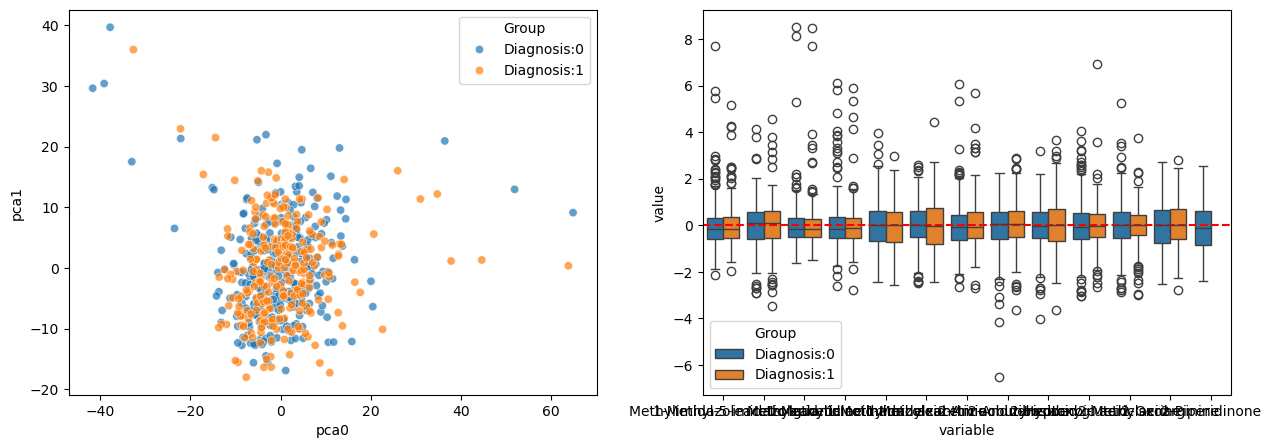

In [ ]:
ST002498.plot_qc()

## Obesity

In [ ]:

ST001412 = WorkbenchDataset(
    study_id='ST001412',
    name='Obesity',
    # filepath='AN002826_updated.csv',
    md_filter={'Control': 'Group:Lean', 'Case': 'Group:Obese neuropathy'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 0.00%
Number of differentially abundant metabolites: 200


c:\Users\cw2019\AppData\Local\R\cache\R\basilisk\1.16.0\0\envs\py12\Lib\site-packages\scipy\stats\_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


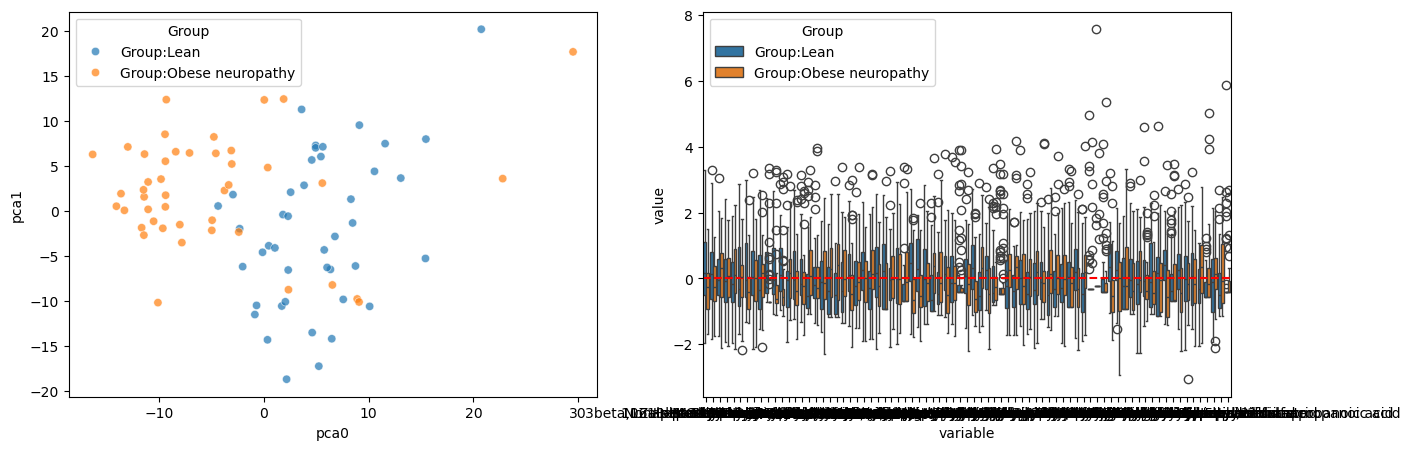

In [ ]:
ST001412.plot_qc()

In [ ]:
ST001412.processed_data.Group.value_counts()

Group
Group:Obese neuropathy    44
Group:Lean                43
Name: count, dtype: int64

## Pre/post exercise

In [ ]:
ST001789 = WorkbenchDataset(
    study_id='ST001789',
    name='Pre/post exercise',
    # filepath='AN002826_updated.csv',
    md_filter={'Control': 'Group:Pre', 'Case': 'Group:Time 60'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 0.00%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 0.00%
Number of differentially abundant metabolites: 220


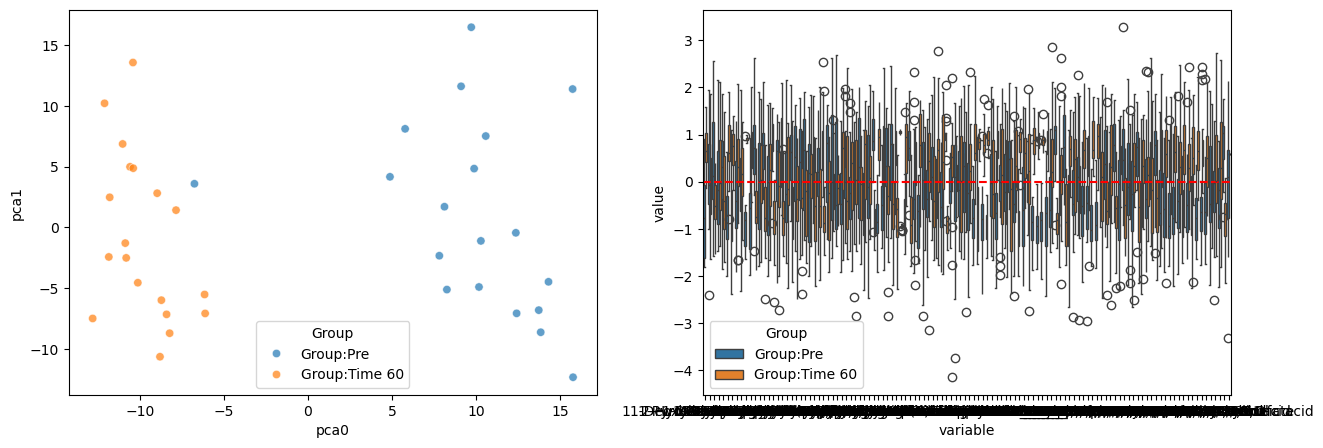

In [ ]:
ST001789.plot_qc()

In [ ]:
ST001789.processed_data.Group.value_counts()

Group
Group:Pre        19
Group:Time 60    19
Name: count, dtype: int64

## Angina

In [ ]:
ST001420 = WorkbenchDataset(
    study_id='ST001420',
    name='Angina',
    outliers=['S17', 'S556'],
    # filepath='AN002826_updated.csv',
    md_filter={'Control': 'Disease:Angina', 'Case': 'Disease:Angina-free'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 0.00%
Number of differentially abundant metabolites: 299


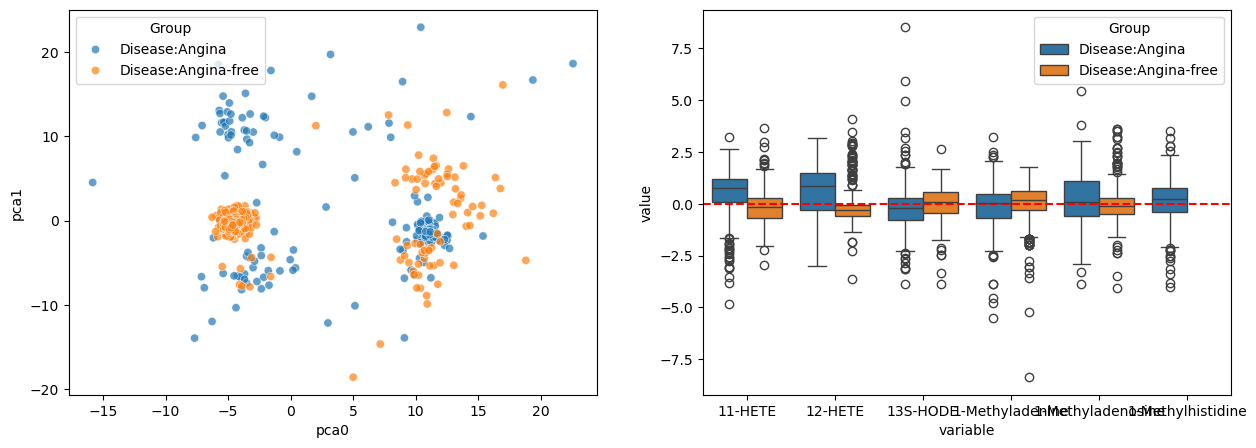

In [ ]:
ST001420.plot_qc()

In [ ]:
ST001420.processed_data.shape

(750, 383)

In [ ]:
ST001420.processed_data.Group.value_counts()

Group
Disease:Angina-free    540
Disease:Angina         210
Name: count, dtype: int64

## COVID severity

In [ ]:
ST002829 = WorkbenchDataset(
    study_id='ST002829',
    name='COVID',
    # outliers=['S17', 'S556'],
    # filepath='AN002826_updated.csv',
    md_filter={'Control': 'Severity_Scale:0', 'Case':'Severity_Scale:3'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 45.87%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 47.42%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 44.65%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_40484\3302181712.py:92: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 44.07%
Number of differentially abundant metabolites: 0


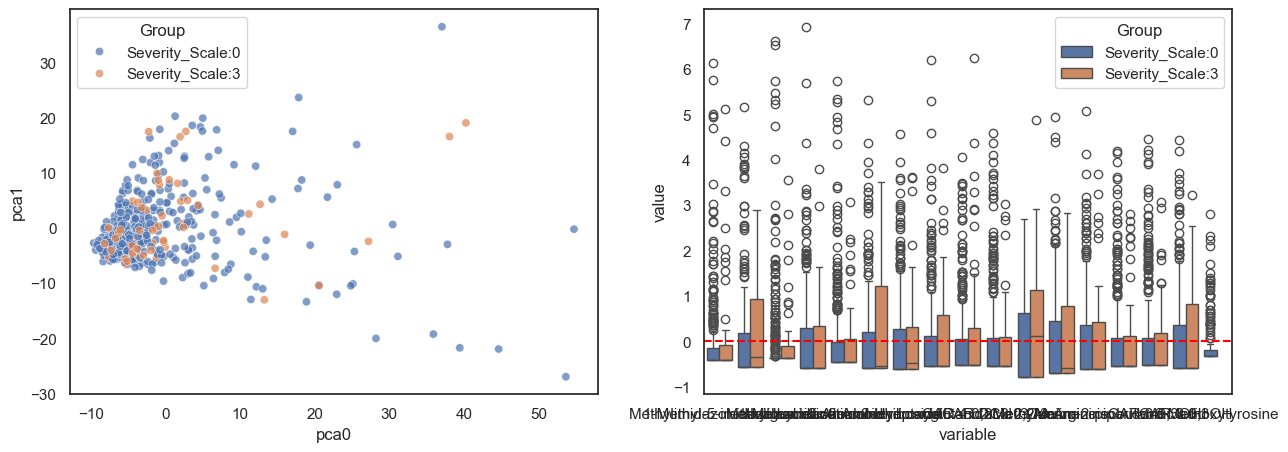

In [ ]:
ST002829.plot_qc()

In [ ]:
ST002829.processed_data.Group.value_counts()

Group
Severity_Scale:0    340
Severity_Scale:3     56
Name: count, dtype: int64

# Network

In [ ]:
studies = [ST001420, ST002016, ST002301, ST001933, ST000899, ST000284, ST002100, ST000974, ST002428, ST002498, ST001412, ST001789]

In [ ]:
def get_bipartite(studies):
    B = nx.Graph()
    # Add nodes with the node attribute "bipartite"-

    B.add_nodes_from([i.node_name for i in studies], bipartite=0)
    B.add_nodes_from(sum([i.DA_metabolites for i in studies], []), bipartite=1)
    # Add edges only between nodes of opposite node sets
    B.add_edges_from(sum([i.connection for i in studies], []))
    bottom_nodes, top_nodes = bipartite.sets(B)
    nx.is_connected(B)
    return B, bottom_nodes, top_nodes


In [ ]:
studies_filt = []
for i in studies:
    print(i.node_name, len(i.DA_metabolites))
    if len(i.DA_metabolites) > 5:
        studies_filt.append(i)

ST001420 299
ST002016 143
ST002301 31
ST001933 1
ST000899 0
ST000284 7
ST002100 46
ST000974 1
ST002428 21
ST002498 1
ST001412 200
ST001789 220


In [ ]:
for s in studies_filt:
    print(s.node_name)
    
    # get the sample size and number of metabolties
    print('sample size', s.processed_data.shape[0]-1)
    print('metabolites', s.processed_data.shape[1])
    print('')

ST001420
sample size 747
metabolites 391

ST002016
sample size 95
metabolites 424

ST002301
sample size 149
metabolites 93

ST000284
sample size 147
metabolites 103

ST002100
sample size 36
metabolites 68

ST002428
sample size 43
metabolites 70

ST001412
sample size 86
metabolites 668

ST001789
sample size 37
metabolites 439



In [ ]:
network_bpt, bottom_nodes, top_nodes = get_bipartite(studies_filt)

In [ ]:
plt.figure(3,figsize=(8,16)) 
nx.draw_networkx(
    network_bpt,
    pos = nx.drawing.layout.bipartite_layout(network_bpt, bottom_nodes),
    font_size=6,
    width = 0.3,
    with_labels=True,
    node_size=10,
    ) # Or whatever other display options you like

plt.show()


NameError: name 'network_bpt' is not defined

<Figure size 800x1600 with 0 Axes>

In [ ]:
study_labels = dict(zip([i.node_name for i in studies_filt], [i.name for i in studies_filt]))

ST001420
ST002016
ST002301
ST000284
ST002100
ST002428
ST001412
ST001789


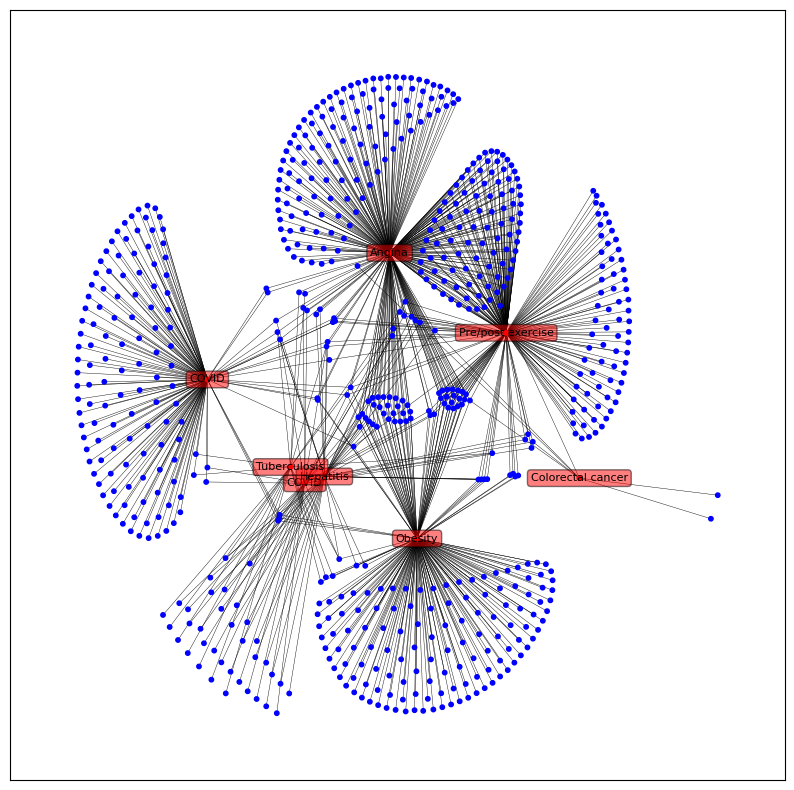

In [ ]:

# force directed layout
pos = nx.drawing.layout.kamada_kawai_layout(network_bpt)
color_map = []
labels = {}
for node in network_bpt:
    if node in bottom_nodes:
        print(node)
        color_map.append('red')
        labels[node] = study_labels[node]
    else: 
        color_map.append('blue')    
        # labels[node] = ''  


plt.figure(3,figsize=(10 ,10)) 
nx.draw_networkx(
    network_bpt,
    pos = pos,
    font_size=6,
    width = 0.3,
    with_labels=False,
    node_size=10,
    node_color=color_map
    ) # Or whatever other display options you like
nx.draw_networkx_labels(network_bpt, pos, labels,
                        bbox = dict(facecolor = "red", alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),
                        font_size=8,
                        font_color='black')

plt.show()

In [ ]:
# remove nodes linking to only one major node (disease)
# they wil all have degree = 1
remove = [node for node,degree in dict(network_bpt.degree()).items() if degree == 1]
bpt_filt = network_bpt
bpt_filt.remove_nodes_from(remove)


In [ ]:
degree_dict = bpt_filt.degree()
degree_dict = dict(degree_dict)
degree_dict = {k: v for k, v in degree_dict.items() if k not in bottom_nodes}
degrees = list(degree_dict.values())
degree_freqs = {i:degrees.count(i) for i in set(degrees)}

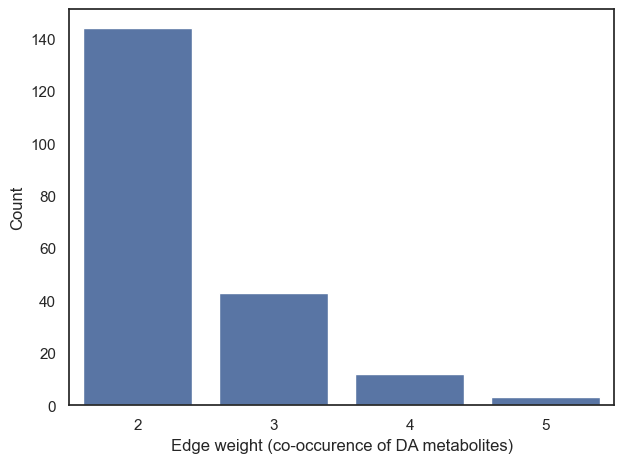

In [ ]:
sns.barplot(
    degree_freqs
)
plt.xlabel('Edge weight (co-occurence of DA metabolites)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
node_degree = dict(zip(range(1, 6), sns.color_palette("Blues", 5)))

In [ ]:
node_degree

{1: (0.8406920415224913, 0.9016378316032295, 0.9586620530565167),
 2: (0.6718954248366014, 0.8143790849673203, 0.9006535947712418),
 3: (0.41708573625528644, 0.6806305267204922, 0.8382314494425221),
 4: (0.21568627450980393, 0.5294117647058824, 0.7542483660130719),
 5: (0.06251441753171857, 0.35750865051903113, 0.6429065743944637)}

ST001420
ST002016
ST002301
ST000284
ST002100
ST002428
ST001412
ST001789


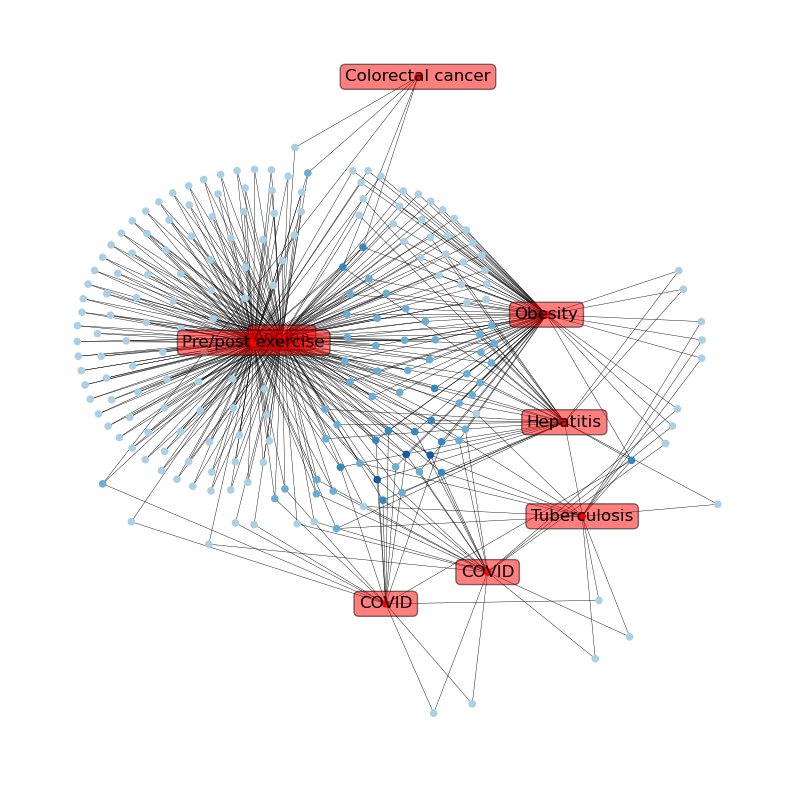

In [ ]:
pos = nx.drawing.layout.kamada_kawai_layout(network_bpt)
color_map = []
labels = {}
for node in network_bpt:
    if node in bottom_nodes:
        print(node)
        color_map.append('red')
        labels[node] = study_labels[node]
    else: 
        color_map.append(node_degree[degree_dict[node]])    
        # labels[node] = ''  
        
plt.figure(3,figsize=(10 ,10)) 
nx.draw_networkx(
    bpt_filt,
    pos = pos,
    font_size=6,
    width = 0.3,
    with_labels=False,
    node_size=20,
    node_color=color_map

    ) # Or whatever other display options you like
nx.draw_networkx_labels(bpt_filt, pos, labels,
                        bbox = dict(facecolor = "red", alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),
                        font_size=12,
                        font_color='black')
plt.box(False)
plt.show()

In [ ]:
# add labels to network nodes rather than study id

label_dict = dict(zip(bottom_nodes, [study_labels[i] for i in bottom_nodes]))

In [ ]:
label_dict

{'ST002016': 'COVID',
 'ST002301': 'COVID',
 'ST000284': 'Colorectal cancer',
 'ST002428': 'Tuberculosis',
 'ST001420': 'Angina',
 'ST002100': 'Hepatitis',
 'ST001789': 'Pre/post exercise',
 'ST001412': 'Obesity'}

In [ ]:
nx.set_node_attributes(bpt_filt, label_dict, 'label_name')

In [ ]:
# export network
nx.write_graphml(bpt_filt, 'multi_disease_workbench_metanet.graphml')

In [ ]:
biadj_mat = nx.bipartite.biadjacency_matrix(network_bpt, row_order=bottom_nodes, column_order=top_nodes).toarray()

# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat = pd.DataFrame(biadj_mat @ biadj_mat.T, index=list(bottom_nodes), columns=list(bottom_nodes))

In [ ]:
adj_mat.index = adj_mat.index.map(study_labels)
adj_mat.columns = adj_mat.index

c:\Users\cw2019\.conda\envs\py12\Lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


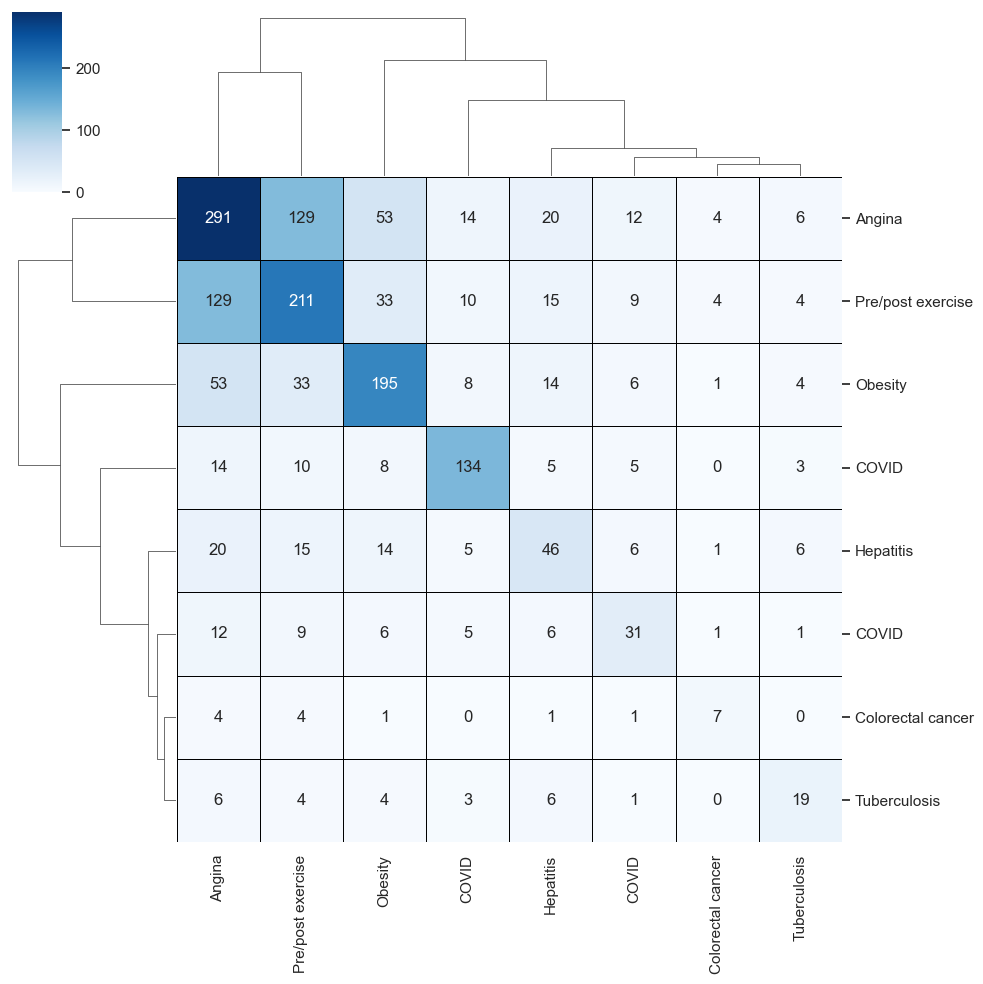

In [ ]:
sns.set(style='white')
sns.clustermap(
    adj_mat, 
    cmap='Blues', 
    square=True, 
    annot=True, 
    # cbar=False, 
    fmt='d', 
    linewidths=0.5, 
    linecolor='black' )

plt.show()


In [ ]:
# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat_dmn = pd.DataFrame(biadj_mat.T @ biadj_mat, index=list(top_nodes), columns=list(top_nodes))

# make pandas edgelist
edgelist_dmn = adj_mat_dmn.stack().reset_index()
edgelist_dmn.columns = ['source', 'target', 'weight']
edgelist_dmn = edgelist_dmn[edgelist_dmn['weight'] > 1]


In [ ]:
edgelist_dmn.sort_values('weight', ascending=False)

,source,target,weight
367302,Cytosine,Cytosine,5
363324,Pantothenic acid,Pantothenic acid,5
134589,Tryptophan,Tryptophan,5
104091,CAR 2:0,CAR 2:0,4
69713,Threonine,Tryptophan,4
...,...,...,...
134660,Tryptophan,Pyruvic acid,2
134654,Tryptophan,Trimethylamine N-oxide,2
134652,Tryptophan,Homoserine,2
134651,Tryptophan,Cer 18:1;O2/22:2;O,2


In [ ]:
# remove self links
edgelist_dmn = edgelist_dmn[edgelist_dmn['source'] != edgelist_dmn['target']]

In [ ]:
edgelist_dmn.sort_values('weight', ascending=False)
dmn_graph = nx.from_pandas_edgelist(edgelist_dmn, edge_attr='weight')
dmn_graph.remove_edges_from(nx.selfloop_edges(dmn_graph))
nx.set_node_attributes(dmn_graph, dict(dmn_graph.degree()), 'degree')

print(dmn_graph.number_of_nodes())
print(dmn_graph.number_of_edges())


201
10077


In [ ]:
biadj_mat_df = pd.DataFrame(biadj_mat, index=list(bottom_nodes), columns=list(top_nodes))
study_contributions = biadj_mat_df.divide(biadj_mat_df.sum(axis=0), axis=1)
# add contribution from each study 
nx.set_node_attributes(dmn_graph, study_contributions.to_dict())


In [ ]:
# add chemical classes
chem_dicts = [i.compound_classes for i in studies_filt]
chem_classes = {k: v for d in chem_dicts for k, v in d.items()}
nx.set_node_attributes(dmn_graph, chem_classes, 'superclass')
# check if any node attributes are none
none_nodes = [k for k, v in nx.get_node_attributes(dmn_graph, 'superclass').items() if v is None]

# replace none with unknown
for node in none_nodes:
    dmn_graph.nodes[node]['superclass'] = 'Unknown'


In [ ]:
len(studies)

12

In [ ]:
# export network
nx.write_graphml(dmn_graph, 'workbench_network_DA.graphml')